In [4]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import measure

fontprops = fm.FontProperties(size=34)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import my_io as io
from config import *

In [8]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split("\\")[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [9]:
dataset = datasets[0]

In [10]:
io.create_folder("stats", data_figure)

Folder is already there


WindowsPath('Y:/coskun-lab/Thomas/SpatialViz/figures/stats')

# Cell area

In [29]:
experiments = ["NT1", "NT3", "DT2", "DT3"]
conditions = ["Healthy", "Healthy", "Diseased", "Diseased"]

In [30]:
df = pd.DataFrame()
for n in range(len(experiments)):
    experiment = experiments[n]

    markers = []
    imgs = []
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / experiment):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                img = cv2.imread(
                    os.path.join(dirpath, name),
                    flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
                )
                imgs.append(img)
                markers.append(name.split("_")[1].split(".")[0])

    for (dirpath, dirnames, filenames) in os.walk(data_mask / experiment):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                img = cv2.imread(os.path.join(dirpath, name), 0)
                masks.append(img)

    # Read cell mask image
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

    max_cell = len(np.unique(cell_mask))

    # Read mean intensity of marker in cell
    marker_area = {}
    for idx, marker in enumerate(markers):
        marker_area[marker] = [
            len(np.unique(cv2.bitwise_and(cell_mask, cell_mask, mask=masks[idx])))
            / max_cell
        ]

    df_temp = pd.DataFrame.from_dict(marker_area)
    df_temp["condition"] = conditions[n]
    df = df.append(df_temp, ignore_index=True)

df = df.drop(columns=["CD44", "H3K9me3", "MHCII"])
df

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,DNA1,DNA2,Ecadherin,FoxP3,GranzymeB,Histone3,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin,condition
0,0.533458,0.545102,0.467621,0.928809,0.212910,0.487671,0.019863,0.996617,0.998298,0.737464,0.163699,0.048007,0.784330,0.219137,0.056746,0.022769,0.061706,0.070942,0.553155,Healthy
1,0.206226,0.300411,0.236627,0.793102,0.566748,0.289701,0.007400,1.000000,1.000000,0.138060,0.044038,0.053093,0.715171,0.062984,0.001291,0.305938,0.028928,0.064966,0.501000,Healthy
2,0.447063,0.357655,0.411101,0.912694,0.653410,0.300248,0.140375,0.968574,0.971982,0.126765,0.022861,0.277586,0.895233,0.139556,0.811889,0.143606,0.105475,0.091090,0.739078,Diseased
3,0.286203,0.240380,0.301941,0.800970,0.451031,0.123835,0.154241,0.998485,0.999198,0.227690,0.078725,0.163687,0.680985,0.059743,0.001836,0.000428,0.166200,0.025933,0.523464,Diseased


In [31]:
# Group markers by cell type
Tcell_markers = ["CD3", "CD4", "CD8a", "CD45RO", "FoxP3"]
Icell_markers = ["CD20", "CD68", "GranzymeB"]
Ecell_markers = ["Ki67", "Pankeratin", "SMA", "Vimentin", "Ecadherin", "Col1"]
all_markers = list(df.columns)[:-1]

In [32]:
def get_df(markers):
    cols = ["Count", "Marker", "Condition"]
    df_temp = pd.DataFrame(columns=cols)
    for ele in all_markers:
        temp = pd.DataFrame(df[[ele]].values, columns=["Count"])
        temp["Marker"] = ele
        temp["Condition"] = df.condition
        df_temp = df_temp.append(temp, ignore_index=True)

    return df_temp


df = get_df(all_markers)

In [33]:
blue_red = ["#3498db", "#e74c3c"]
my_pal = sns.color_palette(blue_red)

In [34]:
df["Percentage Count"] = df["Count"] * 100

<ipython-input-35-53e3771d10eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TCell["Percentage Count"] = df_TCell["Percentage Count"].astype("int")


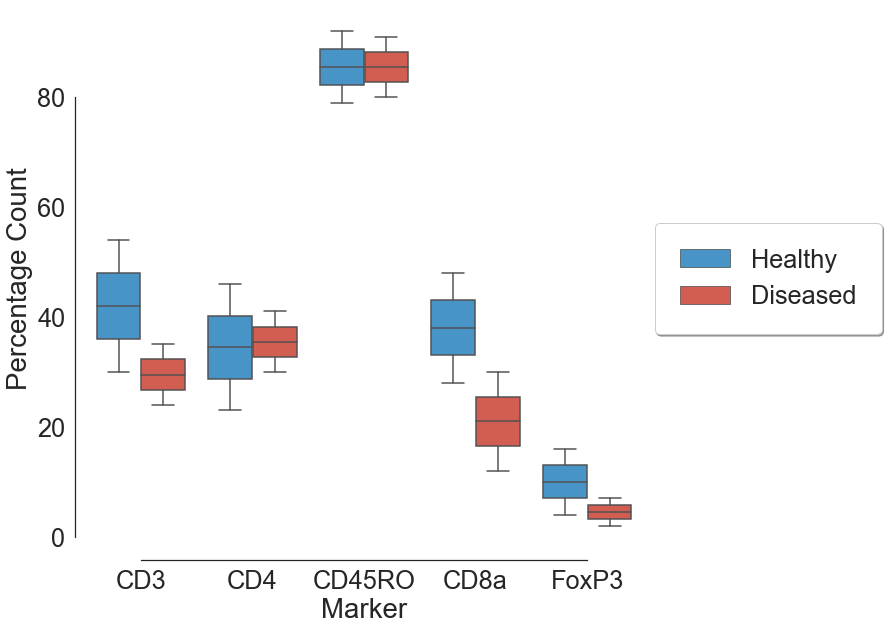

In [35]:
df_TCell = df[df.Marker.isin(Tcell_markers)]
df_TCell["Percentage Count"] = df_TCell["Percentage Count"].astype("int")

sns.set_style("white")
sns.set(font_scale=2.3)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxplot(
        x="Marker", y="Percentage Count", hue="Condition", data=df_TCell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        ncol=1,
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
    fig.savefig(data_figure / "stats" / "count_Tcell.png", bbox_inches="tight")

<ipython-input-36-84df30dc55ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ICell["Percentage Count"] = df_ICell["Percentage Count"].astype("int")


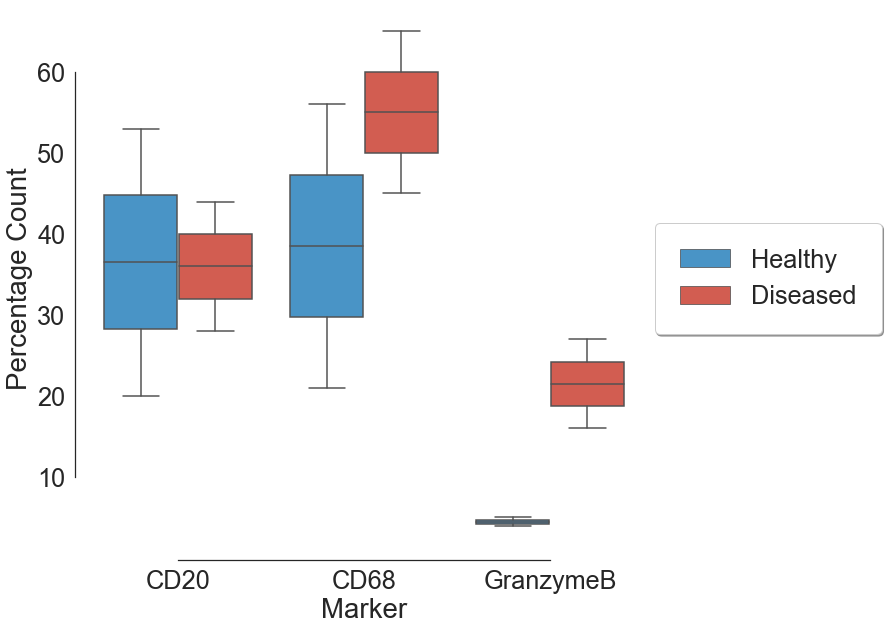

In [36]:
df_ICell = df[df.Marker.isin(Icell_markers)]
df_ICell["Percentage Count"] = df_ICell["Percentage Count"].astype("int")


with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxplot(
        x="Marker", y="Percentage Count", hue="Condition", data=df_ICell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        ncol=1,
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
    fig.savefig(data_figure / "stats" / "count_Icell.png", bbox_inches="tight")

<ipython-input-37-fb41528092d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ECell["Percentage Count"] = df_ECell["Percentage Count"].astype("int")


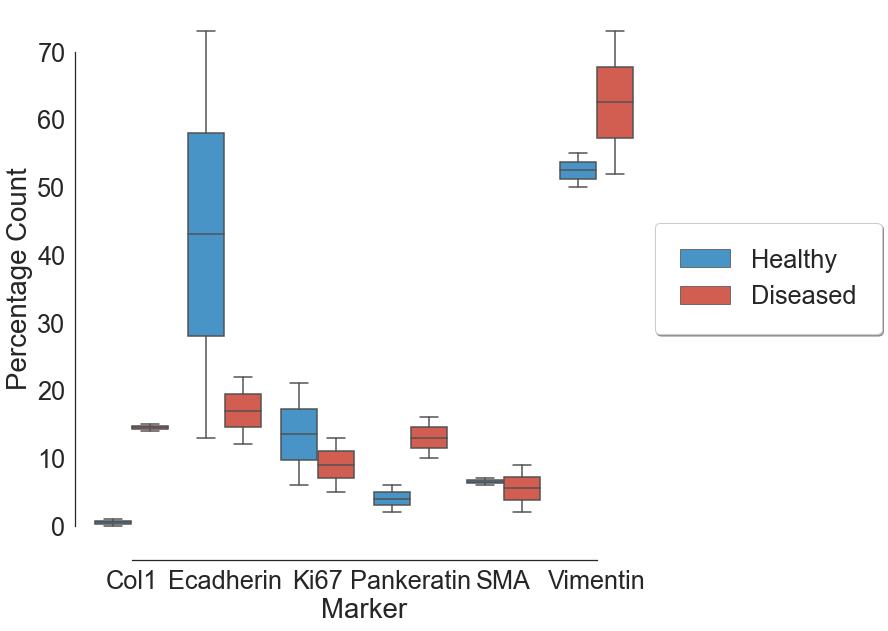

In [37]:
df_ECell = df[df.Marker.isin(Ecell_markers)]
df_ECell["Percentage Count"] = df_ECell["Percentage Count"].astype("int")


with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxplot(
        x="Marker", y="Percentage Count", hue="Condition", data=df_ECell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        ncol=1,
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
    fig.savefig(data_figure / "stats" / "count_ECell.png", bbox_inches="tight")

# Marker intensity

In [38]:
experiments = ["NT4", "NT1", "NT5", "NT3", "DT2", "DT5", "DT3", "DT6"]
conditions = [
    "Healthy",
    "Healthy",
    "Healthy",
    "Healthy",
    "Diseased",
    "Diseased",
    "Diseased",
    "Diseased",
]

In [39]:
df = pd.DataFrame()
for n in range(len(experiments)):
    experiment = experiments[n]

    markers = []
    imgs = []
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(data_raw / experiment):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                img = cv2.imread(
                    os.path.join(dirpath, name),
                    flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH),
                )
                imgs.append(img)
                markers.append(name.split("_")[1].split(".")[0])

    for (dirpath, dirnames, filenames) in os.walk(data_mask / experiment):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                img = cv2.imread(os.path.join(dirpath, name), 0)
                masks.append(img)

    # Read cell mask image
    for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
        for name in sorted(filenames):
            if "tiff" in name and experiment in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath, name)))

    # Read mean intensity of marker in cell
    cell_intensity = {}
    for i in range(len(imgs)):
        prop = measure.regionprops_table(
            cell_mask,
            cv2.bitwise_and(imgs[i], imgs[i], mask=masks[i]),
            properties=["mean_intensity"],
        )
        cell_intensity[markers[i]] = prop["mean_intensity"]

    df_temp = pd.DataFrame.from_dict(cell_intensity)
    df_temp["condition"] = conditions[n]
    df = df.append(df_temp, ignore_index=True)

df = df.drop(columns=["CD44", "H3K9me3", "MHCII"])
df

,CD20,CD3,CD4,CD45RO,CD68,CD8a,Col1,DNA1,DNA2,Ecadherin,FoxP3,GranzymeB,Histone3,Ki67,PD1,PDL1,Pankeratin,SMA,Vimentin,condition
0,15.062500,158.187500,120.312500,199.812500,0.000000,77.843750,0.0,151.281250,155.875000,63.562500,56.250000,0.000000,141.406250,3.125000,0.0,47.937500,0.000000,0.0,197.750000,Healthy
1,52.100000,177.800000,182.266667,177.500000,0.000000,164.100000,0.0,170.600000,180.600000,0.000000,59.500000,0.000000,187.366667,0.000000,0.0,82.766667,0.000000,0.0,201.766667,Healthy
2,0.000000,94.631068,84.990291,129.475728,1.864078,121.242718,0.0,144.504854,155.825243,0.000000,0.000000,0.000000,127.067961,0.000000,0.0,56.233010,0.000000,0.0,169.378641,Healthy
3,19.760563,97.788732,92.281690,176.887324,0.000000,131.971831,0.0,164.154930,162.915493,0.000000,0.000000,0.000000,120.394366,0.000000,0.0,65.859155,0.000000,0.0,113.507042,Healthy
4,29.176471,120.117647,164.235294,160.000000,179.735294,110.264706,0.0,179.088235,189.294118,150.117647,64.970588,118.558824,209.147059,55.617647,0.0,105.441176,0.000000,0.0,109.088235,Healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446119,36.580247,0.000000,0.000000,102.419753,0.000000,0.000000,0.0,96.740741,107.666667,61.061728,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,45.456790,0.0,0.000000,Diseased
446120,0.000000,0.000000,0.000000,44.369863,0.000000,0.000000,0.0,57.150685,74.246575,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Diseased
446121,0.000000,0.000000,0.000000,125.471429,0.000000,0.000000,0.0,73.985714,95.628571,17.728571,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.957143,0.0,0.000000,Diseased
446122,0.000000,0.000000,0.000000,41.304878,0.000000,0.000000,0.0,86.207317,82.926829,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Diseased


In [40]:
# Group markers by cell type
Tcell_markers = ["CD3", "CD4", "CD8a", "CD45RO", "FoxP3"]
Icell_markers = ["CD20", "CD68", "GranzymeB"]
Ecell_markers = ["Ki67", "Pankeratin", "SMA", "Vimentin", "Ecadherin", "Col1"]
all_markers = list(df.columns)[:-1]

In [41]:
def get_df(markers):
    cols = ["Intensity", "Marker", "Condition"]
    df_temp = pd.DataFrame(columns=cols)
    for ele in markers:
        temp = pd.DataFrame(df[[ele]].values, columns=["Intensity"])
        temp["Marker"] = ele
        temp["Condition"] = df.condition
        df_temp = df_temp.append(temp, ignore_index=True)

    return df_temp


df = get_df(all_markers)

In [42]:
blue_red = ["#3498db", "#e74c3c"]
my_pal = sns.color_palette(blue_red)

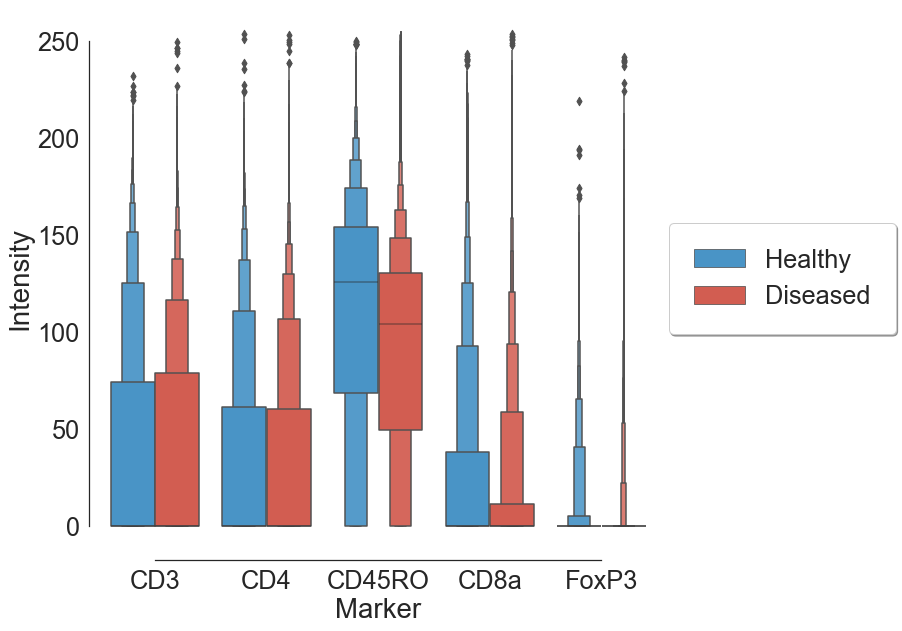

In [43]:
df_TCell = df[df.Marker.isin(Tcell_markers)]

sns.set_style("white")
sns.set(font_scale=2.3)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxenplot(
        x="Marker", y="Intensity", hue="Condition", data=df_TCell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
#     ax = sns.swarmplot(x="Marker", y="Intensity", hue="Condition", data=df_TCell.iloc[::300, :]
# , color=".25", dodge=True, size=5)

    fig.savefig(data_figure / "stats" / "int_TCell.png", bbox_inches="tight")

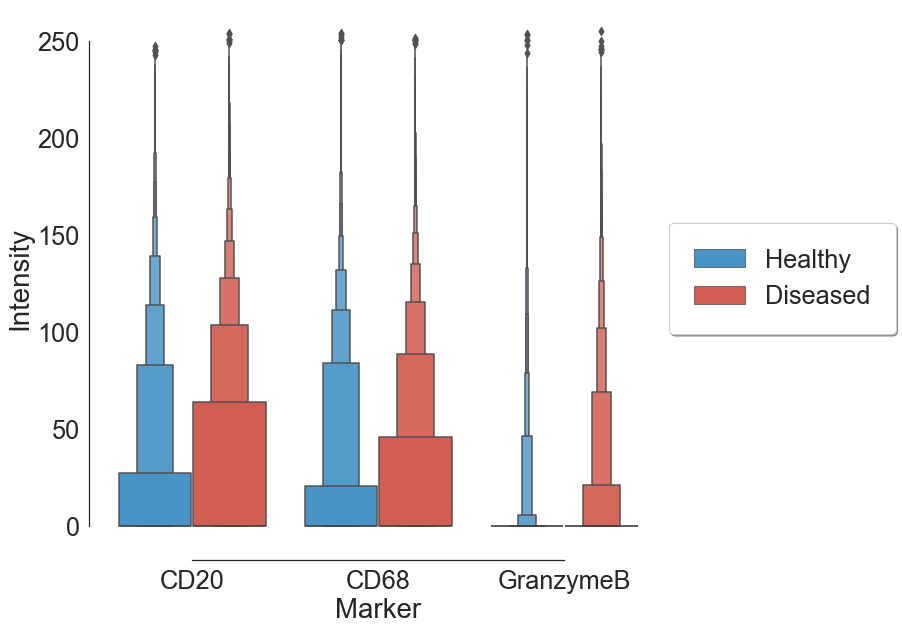

In [44]:
df_ICell = df[df.Marker.isin(Icell_markers)]

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxenplot(
        x="Marker", y="Intensity", hue="Condition", data=df_ICell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        ncol=1,
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
    fig.savefig(data_figure / "stats" / "int_ICell.png", bbox_inches="tight")

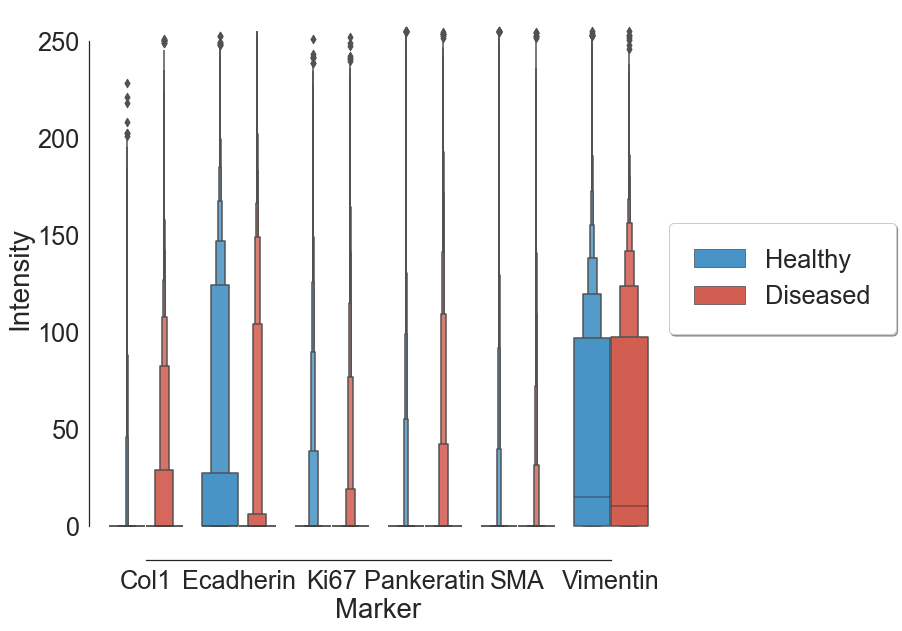

In [45]:
df_ECell = df[df.Marker.isin(Ecell_markers)]

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.boxenplot(
        x="Marker", y="Intensity", hue="Condition", data=df_ECell, palette=my_pal
    )
    ax.legend(
        loc="center right",
        bbox_to_anchor=(1.45, 0.5),
        ncol=1,
        fancybox=True,
        framealpha=1,
        shadow=True,
        borderpad=1,
    )
    sns.despine(offset=10, trim=True, bottom=False)
    fig.savefig(data_figure / "stats" / "int_ECell.png", bbox_inches="tight")